In [ ]:
import tensorflow as tf
from datetime import datetime as dt
import numpy as np
from matplotlib import pyplot as plt

random_seed = 42
tf.random.set_seed(random_seed)
np.random.seed(random_seed)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

def preprocess_images(images):
    images = images.reshape((images.shape[0], 32, 32, 3)).astype('float32') / 255.
    return images

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

length = train_images.shape[1]
width = train_images.shape[2]
channels = train_images.shape[3]

train_size = train_images.shape[0]
test_size = test_images.shape[0]
batch_size = 128

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(train_size).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices(test_images).shuffle(test_size).batch(batch_size)

170508288/170498071 [==============================] - 2s 0us/step


In [ ]:
class Sampling(tf.keras.layers.Layer):
    @tf.function
    def call(self, inputs, training=False):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [ ]:
def get_encoder(input_shape, latent_dim, leaky_alpha, filters, kernel_size, strides, dense_units):
    inputs = tf.keras.Input(shape=input_shape)

    x = tf.keras.layers.Conv2D(filters=filters[0], kernel_size=kernel_size[0], strides=strides[0], padding='same', kernel_regularizer='l2')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(leaky_alpha)(x)

    x = tf.keras.layers.Conv2D(filters=filters[1], kernel_size=kernel_size[1], strides=strides[1], padding='same', kernel_regularizer='l2')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(leaky_alpha)(x)

    x = tf.keras.layers.Conv2D(filters=filters[2], kernel_size=kernel_size[2], strides=strides[2], padding='same', kernel_regularizer='l2')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(leaky_alpha)(x)

    x = tf.keras.layers.Conv2D(filters=filters[3], kernel_size=kernel_size[3], strides=strides[3], padding='same', kernel_regularizer='l2')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(leaky_alpha)(x)

    flatten = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(dense_units[0], activation='relu', kernel_regularizer='l2')(flatten)
    x = tf.keras.layers.BatchNormalization()(x)
    z_mean = tf.keras.layers.Dense(latent_dim)(x)
    z_log_var = tf.keras.layers.Dense(latent_dim)(x)

    z = Sampling()([z_mean, z_log_var])

    model = tf.keras.Model(inputs, z, name="Encoder")
    return model

def get_decoder(input_shape, latent_dim, leaky_alpha, filters, kernel_size, strides, dense_units, stride_reduction):
    inputs = tf.keras.Input(shape=(latent_dim,))

    x = tf.keras.layers.Dense(dense_units[0], activation='relu', kernel_regularizer='l2')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(int(input_shape[0]*input_shape[1]*filters[3]/stride_reduction**2), activation='relu', kernel_regularizer='l2')(x)
    
    reshaped = tf.keras.layers.Reshape((int(input_shape[0]/stride_reduction), int(input_shape[1]/stride_reduction), filters[3]))(x)
    x = tf.keras.layers.Conv2DTranspose(filters=filters[3], kernel_size=kernel_size[3], strides=strides[3], padding='same', kernel_regularizer='l2')(reshaped)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(leaky_alpha)(x)

    x = tf.keras.layers.Conv2DTranspose(filters=filters[2], kernel_size=kernel_size[2], strides=strides[2], padding='same', kernel_regularizer='l2')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(leaky_alpha)(x)

    x = tf.keras.layers.Conv2DTranspose(filters=filters[1], kernel_size=kernel_size[1], strides=strides[1], padding='same', kernel_regularizer='l2')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(leaky_alpha)(x)

    x = tf.keras.layers.Conv2DTranspose(filters=filters[0], kernel_size=kernel_size[0], strides=strides[0], padding='same', kernel_regularizer='l2')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(leaky_alpha)(x)

    image = tf.keras.layers.Conv2DTranspose(filters=input_shape[2], kernel_size=kernel_size[0], strides=1, padding='same', kernel_regularizer='l2')(x)

    model = tf.keras.Model(inputs, image, name="Decoder")
    return model

def get_discriminator(latent_dim, discriminator_units):
    inputs = tf.keras.Input(shape=(latent_dim,))

    x = tf.keras.layers.Dense(discriminator_units[0], activation='relu', kernel_regularizer='l2')(inputs)
    x = tf.keras.layers.Dense(discriminator_units[1], activation='relu', kernel_regularizer='l2')(x)

    vote = tf.keras.layers.Dense(1)(x)

    model = tf.keras.Model(inputs, vote, name="Discriminator")
    return model


    

In [ ]:
class AAE(tf.keras.Model):
    def __init__(self, input_shape, latent_dim, leaky_alpha, filters, kernel_size, strides, dense_units, discriminator_units, base_lr, max_lr, step_size, gen_coef, batch_size):
        super(AAE, self).__init__()

        self.batch_size = batch_size
        # Calculate the stride factor of downsampling
        self.stride_reduction = 1
        for i, stride in enumerate(strides):
            self.stride_reduction = self.stride_reduction * stride
        
        # Latent dimension
        self.latent_dim = latent_dim
        # Define losses and accuracies
        self.mse = tf.keras.losses.MeanSquaredError()
        self.cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
        self.dc_accuracy = tf.keras.metrics.BinaryAccuracy()
        # Define the learning rates for cyclic learning rate (not used)
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.gen_coef = gen_coef

        # Encoder Net
        self.encoder = get_encoder(input_shape, latent_dim, leaky_alpha, filters, kernel_size, strides, dense_units)

        # Decoder Net
        self.decoder = get_decoder(input_shape, latent_dim, leaky_alpha, filters, kernel_size, strides, dense_units, self.stride_reduction)

        # Discriminator Net
        self.discriminator = get_discriminator(latent_dim, discriminator_units)

    def compile(self, ae_opt, dc_opt, gen_opt):
        super(AAE, self).compile()
        # Set optimizers
        self.ae_optimizer = ae_opt
        self.gen_optimizer = gen_opt
        self.dc_optimizer = dc_opt
        # Set loss functions
        self.ae_loss_fn = tf.keras.losses.MeanSquaredError()
        self.binCe_loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
        # Set metrics and accuracies
        self.dc_acc_fn = tf.keras.metrics.BinaryAccuracy(name='dc_accuracy')
        self.ae_metrics = tf.keras.metrics.MeanSquaredError(name='ae_loss')
        self.dc_metrics = tf.keras.metrics.BinaryCrossentropy(from_logits=True, name='dc_loss')
        self.gen_metrics = tf.keras.metrics.BinaryCrossentropy(from_logits=True, name='gen_loss')
        # Compile internal models
        self.encoder.compile()
        self.decoder.compile()
        self.discriminator.compile()

    # Define the metrics
    @property
    def metrics(self):
        return [self.dc_acc_fn, self.ae_metrics, self.dc_metrics, self.gen_metrics]

    # Encoding function
    def encode(self, x, training=False):
        return self.encoder(x, training=training).numpy()

    # Decoding function
    def decode(self, z, apply_sigmoid=True, training=False):
        logits = self.decoder(z, training=training)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs.numpy()
        return logits.numpy()
    
    # Save 10 reconstructions
    def save_10_reconstructions(self, X, epoch):
        fig, ax = plt.subplots(2,5,figsize=(15,5))
        images = X[:10,:,:,:].reshape((10,32,32,3))
        z = self.encode(images)
        image_reconstruction = self.decode(z, apply_sigmoid=True).numpy()
        for i in range(10):
            ax.ravel()[i].imshow(image_reconstruction[i,:])
            ax.ravel()[i].axis(False)
        fig.savefig(f'reconstructed_epoch_{epoch+1:03d}.png',bbox_inches='tight')

    #@tf.function
    def test_step(self, batch_x):
        generated_noise = tf.random.normal([self.batch_size, self.latent_dim], mean=0.0, stddev=1.0)
        z_generated = self.encode(batch_x)
        X_reconstructed = self.decode(z_generated, apply_sigmoid=True)
                
        dc_fake = self.discriminator(z_generated)
        dc_real = self.discriminator(generated_noise)

        self.ae_metrics.update_state(batch_x, X_reconstructed)
        self.dc_metrics.update_state(tf.concat([tf.zeros_like(dc_fake), tf.ones_like(dc_real)], axis=0), tf.concat([dc_fake, dc_real], axis=0))
        self.gen_metrics.update_state(tf.ones_like(dc_fake), dc_fake)
        self.dc_acc_fn.update_state(tf.concat([tf.zeros_like(dc_fake), tf.ones_like(dc_real)], axis=0), tf.concat([dc_fake, dc_real], axis=0))
        return {m.name: m.result() for m in self.metrics}


    # Function for the train step
    #@tf.function
    def train_step(self, batch_x):
        # Autoencoder training
        with tf.GradientTape() as ae_tape:
            z_generated = self.encode(batch_x, training=True)
            X_reconstructed = self.decode(z_generated, apply_sigmoid=True, training=True)
            ae_loss = self.ae_loss_fn(batch_x, X_reconstructed)

        # Apply the gradients
        ae_grads = ae_tape.gradient(ae_loss, self.encoder.trainable_variables + self.decoder.trainable_variables)
        self.ae_optimizer.apply_gradients(zip(ae_grads, self.encoder.trainable_variables + self.decoder.trainable_variables))

        # Discriminator training with normal prior
        generated_noise = tf.random.normal([self.batch_size, self.latent_dim], mean=0.0, stddev=1.0)
        with tf.GradientTape() as dc_tape:
            encoder_output = self.encode(batch_x, training=False)
            dc_fake = self.discriminator(encoder_output, training=True)
            dc_real = self.discriminator(generated_noise, training=True)

            real_loss = self.binCe_loss_fn(tf.ones_like(dc_real), dc_real)
            fake_loss = self.binCe_loss_fn(tf.zeros_like(dc_fake), dc_fake)
            dc_loss = real_loss + fake_loss

            dc_acc = self.dc_acc_fn(tf.concat([tf.ones_like(dc_real), tf.zeros_like(dc_fake)], axis=0),
                        tf.concat([dc_real, dc_fake], axis=0))

        # Apply the gradients
        dc_grads = dc_tape.gradient(dc_loss, self.discriminator.trainable_variables)
        self.dc_optimizer.apply_gradients(zip(dc_grads, self.discriminator.trainable_variables))

        # Generator training (Encoder)
        with tf.GradientTape() as gen_tape:
            encoder_output = self.encode(batch_x, training=True)
            dc_fake = self.discriminator(encoder_output, training=False)
            gen_loss = self.binCe_loss_fn(tf.ones_like(dc_fake),dc_fake)

        # Apply the gradients
        gen_grads = gen_tape.gradient(gen_loss, self.encoder.trainable_variables)
        self.gen_optimizer.apply_gradients(zip(gen_grads, self.encoder.trainable_variables))

        # Update the metrics
        self.ae_metrics.update_state(batch_x, X_reconstructed)
        self.dc_metrics.update_state(tf.concat([tf.zeros_like(dc_fake), tf.ones_like(dc_real)], axis=0), tf.concat([dc_fake, dc_real], axis=0))
        self.gen_metrics.update_state(tf.ones_like(dc_fake), dc_fake)
        self.dc_acc_fn.update_state(tf.concat([tf.zeros_like(dc_fake), tf.ones_like(dc_real)], axis=0), tf.concat([dc_fake, dc_real], axis=0))
        return {m.name: m.result() for m in self.metrics}
    



In [ ]:
base_lr = 0.0001
max_lr = 0.0025
step_size = 2 * np.ceil(train_images.shape[0] / batch_size)
epochs = 150

latent_dim = 256
alpha_leaky = 0.2
filters = [64,128,256,512]
kernel_size = [4,4,3,3]
strides = [2,2,2,2]
dense_units = [1000,300]
discriminator_units = [200, 200]
keep_prob = 0.5
gen_coef = 1.5

steps_per_epoch = train_images.shape[0] / batch_size

aae = AAE((length, width, channels), latent_dim, alpha_leaky, filters, kernel_size, strides, dense_units, discriminator_units, base_lr, max_lr, step_size, gen_coef, batch_size)


In [ ]:
aae.encoder.load_weights('/content/drive/MyDrive/AAE/enc_model')
aae.decoder.load_weights('/content/drive/MyDrive/AAE/dec_model')
aae.discriminator.load_weights('/content/drive/MyDrive/AAE/dc_model')

In [ ]:
filters = [32, 64, 128]
strides = [1, 1, 1]
kernel_size = [3, 3, 3]
dense_dim = [100, 50]
input_shape = (32,32,3)
num_labels = 10

CNN = tf.keras.Sequential(
    [
    tf.keras.layers.InputLayer(input_shape=input_shape),
    tf.keras.layers.Conv2D(filters=filters[0], kernel_size=kernel_size[0], strides=strides[0], activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(filters=filters[1], kernel_size=kernel_size[1], strides=strides[1], activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(filters=filters[2], kernel_size=kernel_size[2], strides=strides[2], activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(dense_dim[0], activation='relu'),
    tf.keras.layers.Dense(dense_dim[1], activation='relu'),
    tf.keras.layers.Dense(num_labels),
    ]
)

CNN.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

In [ ]:
CNN = tf.keras.models.load_model('/content/drive/MyDrive/Blackboxes/CNN_black_box')

In [ ]:
!git clone https://github.com/francescanaretto/XAI-course_2021.git

Cloning into 'XAI-course_2021'...
remote: Enumerating objects: 1041, done.
remote: Counting objects: 100% (264/264), done.
remote: Compressing objects: 100% (221/221), done.
remote: Total 1041 (delta 44), reused 260 (delta 40), pack-reused 777
Receiving objects: 100% (1041/1041), 561.90 MiB | 32.31 MiB/s, done.
Resolving deltas: 100% (261/261), done.
Checking out files: 100% (465/465), done.


In [ ]:
cd /content/XAI-course_2021/Images/

/content/XAI-course_2021/Images


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import warnings
warnings.filterwarnings("ignore")

In [ ]:
!pip install deap

     |████████████████████████████████| 160 kB 3.3 MB/s 


In [ ]:
import numpy as np

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time
from skimage.color import gray2rgb, rgb2gray
from skimage import feature, transform

from xailib.explainers.abele_explainer import ABELEImageExplainer
#from externals.ABELE.experiments.exputil import get_dataset
#from externals.ABELE.experiments.exputil import get_autoencoder

import warnings
warnings.filterwarnings('ignore')

random_state = 42
dataset = 'custom' 
black_box = 'AB' #agnostic Black Box

# load autoencoder and black box
ae_name = 'aae' 
path = './' 
path_aemodels = path + 'models/abele/%s/%s/' % (dataset, ae_name)
bb = tf.keras.models.load_model("/content/drive/MyDrive/Blackboxes/CNN_black_box")
#bb = MNIST_CNN

# defining a functions for bb to return the class index value
def bb_predict(X):
    X = X.astype(float)
    Y = bb.predict(X)   
    return np.argmax(Y, axis=1)
#def bb_predict(X):
#    X = X.astype(float)
#    Y = bb.predict(rgb2gray(X).reshape(-1,28,28,1))   
#    return np.argmax(Y, axis=1)

# load data
#X_train, Y_train, X_test, Y_test, _ = get_dataset(dataset)

# load auto encoder
#ae = get_autoencoder(X_train, ae_name, path_aemodels, dataset)
#ae.load_model()

# index Image 2 Explain
img = test_images[20]
# time
start = time.time()

# create explainer
"""
Arguments:
    bb_predict: function which return the prediction of the blackbox in form index of the class 
    class_name: name of the class used when printing rules (class_name: class_value)
    class_values: list of names of the classes (class_name: class_value)
    neigh_type: select the nighbourhood type,
                supportecd types:
                'gnt' : genetic
                'rnd' : random
                'hrg' : hybrid-random-genetic
                'gntp': genetic probabilistic
                'hrgp': hybrid probabilistic
    ocr: [0.1] other class values, ratio of other class from the one predicted in the neighbourhood
    kernel: [None] Kernel to weights the point in the nieghbourhood
    kernel_width : [None]  
    autoencoder: Autoencoder to generate the latent space points
    use_rgb = [True] Set to True if the input images are rgb, False for grayscale
    filter_crules: [None] if True Prototypes are checked by the black box to be the same class of the query image
    random_state: set the seed of the random state
    verbose: True if you want to print more informations
    NEIGHBOURHOOD PARAMETERS: the following parameters are Neighbourhood specific and may not apply to all of the neighbourhood types
        valid_thr: [0.5] threshold to change class in the autoencoder disciminator
        alpha1: [0.5] weight of the feature similarity of the neighbourhood points
        alpha2: [0.5] weight of the target similarity of the neighbourhood points
        ngen: [100] number of generations of the genetic algorithm
        mutpb: [0.2] The probability of mutating an individual in the genetic algorithm
        cxpb: [0.5] The probability of mating two individuals in the genetic algorithm
        tournsize: [3] number of tournaments in the genetic algorithm
        hallooffame_ratio: [0.1] Fraction of exemplars to keep at every genetic generation
"""
config = {'bb_predict':bb_predict,
          'class_name':'class',
          'class_values':['%s' % i for i in range(len(np.unique(test_labels)))],
          'neigh_type':'hrg', 
          'ocr':0.1, #other class ratio in the neighbourhood
          'kernel_width':None, 
          'kernel':None, 
          'autoencoder':aae, 
          'use_rgb':True, 
          'filter_crules':False, 
          'random_state':random_state, 
          'verbose':True, 
          'valid_thr':0.5,
          'alpha1':0.5, 
          'alpha2':0.5, 
          'ngen':20, 
          'mutpb':0.2, 
          'cxpb':0.5, 
          'tournsize':3, 
          'halloffame_ratio':0.1}


explainer = ABELEImageExplainer(bb)
explainer.fit(config)

#generate explanation
"""
generate an explanation for a given image
Arguments:
    img: the image to explain
    num_samples: [1000] number of samples to generate with the neighbourhood algorithm
    use_weights: [True] if weights the points using distance
Return:
Explanation object compose by several things
    rstr: string describing the rule
    cstr: string describing the counterfactual rule
    bb_pred: black box prediction of the image
    dt_pred: decisoon tree prediction
    fidelity: fidelity between black box and the decision tree
    limg: latent space representation of the image
"""
exp = explainer.explain(img, num_samples=500, use_weights=True)

# time
end = time.time()
print('--------------------------')
print('execution time: ',end - start,' sec')
print('e = {\n\tr = %s\n\tc = %s    \n}' % (exp.getRules(), exp.getCounterfactualRules()))
print('--------------------------')
print('bb prediction of the image: ',exp.exp.bb_pred,'dt prediction: ',exp.exp.dt_pred,'fidelity: ',exp.exp.fidelity)
print('latent space representation: ',exp.exp.limg)

generating neighborhood - hrg
gen	nevals	avg     	min     	max     
0  	125   	0.496654	0.496654	0.496654
1  	87    	0.527538	0.486949	0.989721
2  	78    	0.59807 	0.486382	0.993004
3  	81    	0.738742	0.451351	0.993004
4  	67    	0.864885	0.481434	0.993004
5  	78    	0.897167	0.476899	0.993004
6  	79    	0.942178	0.481827	0.993004
7  	72    	0.923469	0.479428	0.993247
8  	72    	0.931478	0.486787	0.993247
9  	71    	0.896419	0.489126	0.993247
10 	72    	0.92045 	0.484076	0.993247
11 	57    	0.928587	0.484559	0.993247
12 	68    	0.936407	0.482827	0.993247
13 	70    	0.904488	0.48618 	0.993247
14 	74    	0.936253	0.484887	0.993247
15 	76    	0.932606	0.47904 	0.993247
16 	80    	0.944706	0.47753 	0.993247
17 	73    	0.952642	0.487504	0.993247
18 	72    	0.936255	0.481532	0.993247
19 	71    	0.940267	0.480282	0.993247
20 	73    	0.932517	0.48827 	0.993247
gen	nevals	avg	min	max
0  	125   	0.5	0.5	0.5
1  	81    	0.569274	0.489274	0.989235
2  	89    	0.711118	0.477037	0.992141
3  	81    	0

In [ ]:
"""
Arguments:
    features: [None] list of which feature of the latent space to use, If None use all
    samples: [10] number of prototype to use
Return the image and the difference between the prototypes
"""
img2show, mask = exp.getFeaturesImportance(features=None, samples=1500)

# Plot Script
F, ax = plt.subplots(1,2, figsize=(10,5))
if use_rgb:
    ax[0].imshow(img2show)
else:
    ax[0].imshow(img2show, cmap='gray')
bbo = bb_predict(np.array([img2show]))[0]
ax[0].set_title('Image to explain - black box %s' % bbo)
ax[0].axis('off')
dx, dy = 0.05, 0.05
xx = np.arange(0.0, img2show.shape[1], dx)
yy = np.arange(0.0, img2show.shape[0], dy)
xmin, xmax, ymin, ymax = np.amin(xx), np.amax(xx), np.amin(yy), np.amax(yy)
extent = xmin, xmax, ymin, ymax
cmap_xi = plt.get_cmap('Greys_r')
cmap_xi.set_bad(alpha=0)
# Compute edges (to overlay to heatmaps later)
percentile = 100
dilation = 3.0
alpha = 0.8
xi_greyscale = img2show if len(img2show.shape) == 2 else np.mean(img2show, axis=-1)
in_image_upscaled = transform.rescale(xi_greyscale, dilation, mode='constant')
edges = feature.canny(in_image_upscaled).astype(float)
edges[edges < 0.5] = np.nan
edges[:5, :] = np.nan
edges[-5:, :] = np.nan
edges[:, :5] = np.nan
edges[:, -5:] = np.nan
overlay = edges
ax[1].imshow(mask, extent=extent, cmap=plt.cm.BrBG, alpha=1, vmin=0, vmax=255)
ax[1].imshow(overlay, extent=extent, interpolation='none', cmap=cmap_xi, alpha=alpha)
ax[1].axis('off')
ax[1].set_title('Attention area respecting latent rule');

Exception: ignored

In [ ]:
"""
Return the prototypes images
Arguments:
    num_prototypes: [5]  maximum number of prototypes to return
    return_latent: [False] if True return latent representation
    return_diff: [False] If True return the difference with the query image
    features: [None] list of the features in the latent space to use, if none use all
"""
proto = exp.getExemplars(num_prototypes=5)
#print(proto)
#F, ax = plt.subplots(1,len(proto),figsize=(30,5))
#for i in range(len(proto)):
#    ax[i].imshow(proto[i])
#    ax[i].axis('off')

if len(proto)==1:
    plt.imshow(proto[0])
    plt.axis(False)
    plt.title('model prediction: '+str(bb_predict(proto[0][np.newaxis,:,:,:])[0]))
else:
    F, ax = plt.subplots(1,len(proto),figsize=(30,5))
    for i in range(len(proto)):
        ax[i].imshow(proto[i])
        ax[i].set_title('model prediction: '+str(bb_predict(proto[i][np.newaxis,:,:,:])[0]))
        ax[i].axis('off')

In [ ]:
print(proto)

In [ ]:
"""
Return the couterfactuals satisfying the counterfactual rule
"""
counter = exp.getCounterExemplars()

if len(counter)==1:
    plt.imshow(counter[0])
    plt.axis(False)
    plt.title('model prediction: '+str(bb_predict(counter[0][np.newaxis,:,:,:])[0]))
else:
    F, ax = plt.subplots(1,len(counter),figsize=(30,5))
    for i in range(len(counter)):
        ax[i].imshow(counter[i])
        ax[i].set_title('model prediction: '+str(bb_predict(counter[i][np.newaxis,:,:,:])[0]))
        ax[i].axis('off')

In [ ]:
# index Image 2 Explain
img = test_images[10]
# time
start = time.time()

# create explainer
"""
Arguments:
    bb_predict: function which return the prediction of the blackbox in form index of the class 
    class_name: name of the class used when printing rules (class_name: class_value)
    class_values: list of names of the classes (class_name: class_value)
    neigh_type: select the nighbourhood type,
                supportecd types:
                'gnt' : genetic
                'rnd' : random
                'hrg' : hybrid-random-genetic
                'gntp': genetic probabilistic
                'hrgp': hybrid probabilistic
    ocr: [0.1] other class values, ratio of other class from the one predicted in the neighbourhood
    kernel: [None] Kernel to weights the point in the nieghbourhood
    kernel_width : [None]  
    autoencoder: Autoencoder to generate the latent space points
    use_rgb = [True] Set to True if the input images are rgb, False for grayscale
    filter_crules: [None] if True Prototypes are checked by the black box to be the same class of the query image
    random_state: set the seed of the random state
    verbose: True if you want to print more informations
    NEIGHBOURHOOD PARAMETERS: the following parameters are Neighbourhood specific and may not apply to all of the neighbourhood types
        valid_thr: [0.5] threshold to change class in the autoencoder disciminator
        alpha1: [0.5] weight of the feature similarity of the neighbourhood points
        alpha2: [0.5] weight of the target similarity of the neighbourhood points
        ngen: [100] number of generations of the genetic algorithm
        mutpb: [0.2] The probability of mutating an individual in the genetic algorithm
        cxpb: [0.5] The probability of mating two individuals in the genetic algorithm
        tournsize: [3] number of tournaments in the genetic algorithm
        hallooffame_ratio: [0.1] Fraction of exemplars to keep at every genetic generation
"""
config = {'bb_predict':bb_predict,
          'class_name':'class',
          'class_values':['%s' % i for i in range(len(np.unique(test_labels)))],
          'neigh_type':'hrg', 
          'ocr':0.1, #other class ratio in the neighbourhood
          'kernel_width':None, 
          'kernel':None, 
          'autoencoder':aae, 
          'use_rgb':True, 
          'filter_crules':False, 
          'random_state':random_state, 
          'verbose':True, 
          'valid_thr':0.5,
          'alpha1':0.5, 
          'alpha2':0.5, 
          'ngen':20, 
          'mutpb':0.2, 
          'cxpb':0.5, 
          'tournsize':3, 
          'halloffame_ratio':0.1}


explainer = ABELEImageExplainer(bb)
explainer.fit(config)

#generate explanation
"""
generate an explanation for a given image
Arguments:
    img: the image to explain
    num_samples: [1000] number of samples to generate with the neighbourhood algorithm
    use_weights: [True] if weights the points using distance
Return:
Explanation object compose by several things
    rstr: string describing the rule
    cstr: string describing the counterfactual rule
    bb_pred: black box prediction of the image
    dt_pred: decisoon tree prediction
    fidelity: fidelity between black box and the decision tree
    limg: latent space representation of the image
"""
exp = explainer.explain(img, num_samples=500, use_weights=False)

# time
end = time.time()
print('--------------------------')
print('execution time: ',end - start,' sec')
print('e = {\n\tr = %s\n\tc = %s    \n}' % (exp.getRules(), exp.getCounterfactualRules()))
print('--------------------------')
print('bb prediction of the image: ',exp.exp.bb_pred,'dt prediction: ',exp.exp.dt_pred,'fidelity: ',exp.exp.fidelity)
print('latent space representation: ',exp.exp.limg)

generating neighborhood - hrg
gen	nevals	avg     	min     	max     
0  	125   	0.496654	0.496654	0.496654
1  	87    	0.523174	0.483112	0.988813
2  	78    	0.628267	0.466581	0.993305
3  	81    	0.784841	0.458393	0.993305
4  	67    	0.900435	0.463477	0.993305
5  	78    	0.898223	0.474791	0.993305
6  	79    	0.887687	0.473898	0.993305
7  	72    	0.927991	0.482763	0.993305
8  	72    	0.895878	0.479073	0.993305
9  	71    	0.904146	0.477475	0.993305
10 	72    	0.928487	0.48349 	0.993305
11 	57    	0.92058 	0.481971	0.993305
12 	68    	0.928449	0.480487	0.993305
13 	70    	0.915863	0.478886	0.993305
14 	74    	0.924074	0.485792	0.993305
15 	76    	0.912509	0.469081	0.993305
16 	80    	0.952173	0.48549 	0.993305
17 	73    	0.924575	0.483099	0.993305
18 	72    	0.928323	0.485106	0.993305
19 	71    	0.943565	0.461999	0.993305
20 	73    	0.924182	0.485881	0.993305
gen	nevals	avg	min	max
0  	125   	0.5	0.5	0.5
1  	81    	0.596261	0.4848	0.987835
2  	89    	0.814299	0.474097	0.992255
3  	81    	0.9

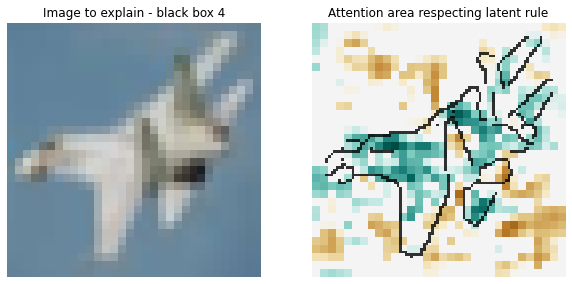

In [ ]:

"""
Arguments:
    features: [None] list of which feature of the latent space to use, If None use all
    samples: [10] number of prototype to use
Return the image and the difference between the prototypes
"""
img2show, mask = exp.getFeaturesImportance(features=None, samples=1000)

# Plot Script
F, ax = plt.subplots(1,2, figsize=(10,5))
if use_rgb:
    ax[0].imshow(img2show)
else:
    ax[0].imshow(img2show, cmap='gray')
bbo = bb_predict(np.array([img2show]))[0]
ax[0].set_title('Image to explain - black box %s' % bbo)
ax[0].axis('off')
dx, dy = 0.05, 0.05
xx = np.arange(0.0, img2show.shape[1], dx)
yy = np.arange(0.0, img2show.shape[0], dy)
xmin, xmax, ymin, ymax = np.amin(xx), np.amax(xx), np.amin(yy), np.amax(yy)
extent = xmin, xmax, ymin, ymax
cmap_xi = plt.get_cmap('Greys_r')
cmap_xi.set_bad(alpha=0)
# Compute edges (to overlay to heatmaps later)
percentile = 100
dilation = 3.0
alpha = 0.8
xi_greyscale = img2show if len(img2show.shape) == 2 else np.mean(img2show, axis=-1)
in_image_upscaled = transform.rescale(xi_greyscale, dilation, mode='constant')
edges = feature.canny(in_image_upscaled).astype(float)
edges[edges < 0.5] = np.nan
edges[:5, :] = np.nan
edges[-5:, :] = np.nan
edges[:, :5] = np.nan
edges[:, -5:] = np.nan
overlay = edges
ax[1].imshow(mask, extent=extent, cmap=plt.cm.BrBG, alpha=1, vmin=0, vmax=255)
ax[1].imshow(overlay, extent=extent, interpolation='none', cmap=cmap_xi, alpha=alpha)
ax[1].axis('off')
ax[1].set_title('Attention area respecting latent rule');

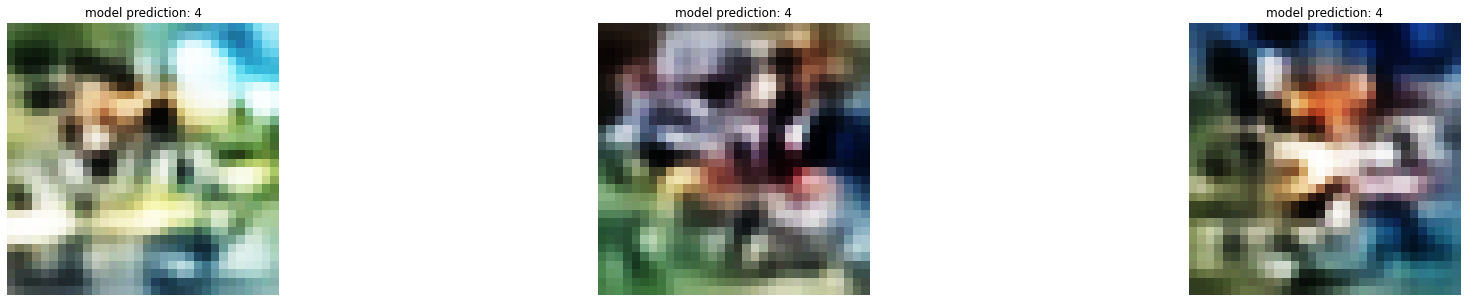

In [ ]:
"""
Return the prototypes images
Arguments:
    num_prototypes: [5]  maximum number of prototypes to return
    return_latent: [False] if True return latent representation
    return_diff: [False] If True return the difference with the query image
    features: [None] list of the features in the latent space to use, if none use all
"""
proto = exp.getExemplars(num_prototypes=5)
#print(proto)
#F, ax = plt.subplots(1,len(proto),figsize=(30,5))
#for i in range(len(proto)):
#    ax[i].imshow(proto[i])
#    ax[i].axis('off')

if len(proto)==1:
    plt.imshow(proto[0])
    plt.axis(False)
    plt.title('model prediction: '+str(bb_predict(proto[0][np.newaxis,:,:,:])[0]))
else:
    F, ax = plt.subplots(1,len(proto),figsize=(30,5))
    for i in range(len(proto)):
        ax[i].imshow(proto[i])
        ax[i].set_title('model prediction: '+str(bb_predict(proto[i][np.newaxis,:,:,:])[0]))
        ax[i].axis('off')

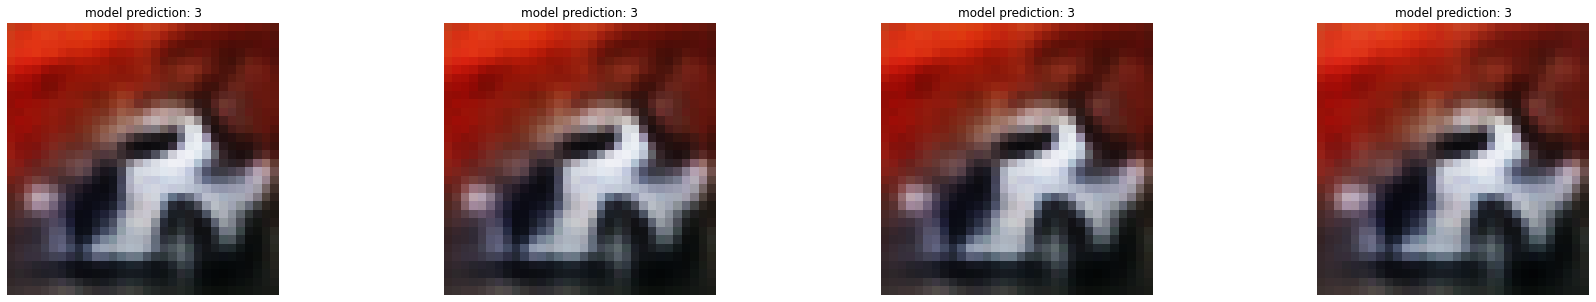

In [ ]:
"""
Return the couterfactuals satisfying the counterfactual rule
"""
counter = exp.getCounterExemplars()

if len(counter)==1:
    plt.imshow(counter[0])
    plt.axis(False)
    plt.title('model prediction: '+str(bb_predict(counter[0][np.newaxis,:,:,:])[0]))
else:
    F, ax = plt.subplots(1,len(counter),figsize=(30,5))
    for i in range(len(counter)):
        ax[i].imshow(counter[i])
        ax[i].set_title('model prediction: '+str(bb_predict(counter[i][np.newaxis,:,:,:])[0]))
        ax[i].axis('off')

In [ ]:
# index Image 2 Explain
img = test_images[6]
# time
start = time.time()

# create explainer
"""
Arguments:
    bb_predict: function which return the prediction of the blackbox in form index of the class 
    class_name: name of the class used when printing rules (class_name: class_value)
    class_values: list of names of the classes (class_name: class_value)
    neigh_type: select the nighbourhood type,
                supportecd types:
                'gnt' : genetic
                'rnd' : random
                'hrg' : hybrid-random-genetic
                'gntp': genetic probabilistic
                'hrgp': hybrid probabilistic
    ocr: [0.1] other class values, ratio of other class from the one predicted in the neighbourhood
    kernel: [None] Kernel to weights the point in the nieghbourhood
    kernel_width : [None]  
    autoencoder: Autoencoder to generate the latent space points
    use_rgb = [True] Set to True if the input images are rgb, False for grayscale
    filter_crules: [None] if True Prototypes are checked by the black box to be the same class of the query image
    random_state: set the seed of the random state
    verbose: True if you want to print more informations
    NEIGHBOURHOOD PARAMETERS: the following parameters are Neighbourhood specific and may not apply to all of the neighbourhood types
        valid_thr: [0.5] threshold to change class in the autoencoder disciminator
        alpha1: [0.5] weight of the feature similarity of the neighbourhood points
        alpha2: [0.5] weight of the target similarity of the neighbourhood points
        ngen: [100] number of generations of the genetic algorithm
        mutpb: [0.2] The probability of mutating an individual in the genetic algorithm
        cxpb: [0.5] The probability of mating two individuals in the genetic algorithm
        tournsize: [3] number of tournaments in the genetic algorithm
        hallooffame_ratio: [0.1] Fraction of exemplars to keep at every genetic generation
"""
config = {'bb_predict':bb_predict,
          'class_name':'class',
          'class_values':['%s' % i for i in range(len(np.unique(test_labels)))],
          'neigh_type':'hrg', 
          'ocr':0.1, #other class ratio in the neighbourhood
          'kernel_width':None, 
          'kernel':None, 
          'autoencoder':aae, 
          'use_rgb':True, 
          'filter_crules':False, 
          'random_state':random_state, 
          'verbose':True, 
          'valid_thr':0.5,
          'alpha1':0.5, 
          'alpha2':0.5, 
          'ngen':20, 
          'mutpb':0.2, 
          'cxpb':0.5, 
          'tournsize':3, 
          'halloffame_ratio':0.1}


explainer = ABELEImageExplainer(bb)
explainer.fit(config)

#generate explanation
"""
generate an explanation for a given image
Arguments:
    img: the image to explain
    num_samples: [1000] number of samples to generate with the neighbourhood algorithm
    use_weights: [True] if weights the points using distance
Return:
Explanation object compose by several things
    rstr: string describing the rule
    cstr: string describing the counterfactual rule
    bb_pred: black box prediction of the image
    dt_pred: decisoon tree prediction
    fidelity: fidelity between black box and the decision tree
    limg: latent space representation of the image
"""
exp = explainer.explain(img, num_samples=500, use_weights=True)

# time
end = time.time()
print('--------------------------')
print('execution time: ',end - start,' sec')
print('e = {\n\tr = %s\n\tc = %s    \n}' % (exp.getRules(), exp.getCounterfactualRules()))
print('--------------------------')
print('bb prediction of the image: ',exp.exp.bb_pred,'dt prediction: ',exp.exp.dt_pred,'fidelity: ',exp.exp.fidelity)
print('latent space representation: ',exp.exp.limg)

generating neighborhood - hrg
gen	nevals	avg     	min     	max     
0  	125   	0.496654	0.496654	0.496654
1  	87    	0.528098	0.494664	0.990541
2  	78    	0.622267	0.482151	0.993284
3  	81    	0.732075	0.478259	0.993284
4  	67    	0.847153	0.485504	0.993284
5  	78    	0.872291	0.487361	0.993284
6  	79    	0.877081	0.490959	0.993284
7  	72    	0.885576	0.489247	0.993284
8  	72    	0.881737	0.489965	0.993284
9  	71    	0.909447	0.492619	0.993284
10 	72    	0.929419	0.494495	0.993284
11 	57    	0.933528	0.494265	0.993284
12 	68    	0.925486	0.493461	0.993284
13 	70    	0.889713	0.490568	0.993284
14 	74    	0.909414	0.49109 	0.993284
15 	76    	0.917403	0.485177	0.993284
16 	80    	0.917589	0.49005 	0.993284
17 	73    	0.917629	0.492177	0.993284
18 	72    	0.897663	0.492804	0.993284
19 	71    	0.905446	0.492808	0.993284
20 	73    	0.909526	0.490432	0.993284
gen	nevals	avg	min	max
0  	125   	0.5	0.5	0.5
1  	81    	0.589836	0.492652	0.991709
2  	89    	0.788497	0.484858	0.993184
3  	81    	0

In [ ]:
import time
from skimage.color import gray2rgb, rgb2gray
from skimage import feature, transform
#disable eager execution in tensorflow 2.x for faster training time
#from tensorflow.python.framework.ops import disable_eager_execution
#disable_eager_execution()

from externals.ABELE.ilore.ilorem import ILOREM
from externals.ABELE.ilore.util import neuclidean

#from externals.ABELE.experiments.exputil import get_dataset
#from externals.ABELE.experiments.exputil import get_autoencoder

import warnings
warnings.filterwarnings('ignore')

random_state = 42
dataset = 'custom' 
black_box = 'AB' #agnostic Black Box

# load autoencoder and black box
ae_name = 'aae' 
path = './' 
#path_aemodels = path + 'models/abele/%s/%s/' % (dataset, ae_name)
bb = tf.keras.models.load_model("/content/drive/MyDrive/Blackboxes/CNN_black_box")
# defining a functions for bb to return the class index value
def bb_predict(X):
    X = X.astype(float)
    Y = bb.predict(X)   
    return np.argmax(Y, axis=1)

# load data
dataset = 'custom'
use_rgb=True

# load auto encoder

class_name = 'class'
class_values = ['%s' % i for i in range(len(np.unique(test_labels)))]

# index Image 2 Explain
img = test_images[9836]
# time
start = time.time()
# create explainer
"""
Arguments:
    bb_predict: function which return the prediction of the blackbox in form index of the class 
    class_name: name of the class used when printing rules (class_name: class_value)
    class_values: list of names of the classes (class_name: class_value)
    neigh_type: select the nighbourhood type,
                supportecd types:
                'gnt' : genetic
                'rnd' : random
                'hrg' : hybrid-random-genetic
                'gntp': genetic probabilistic
                'hrgp': hybrid probabilistic
    ocr: [0.1] other class values, ratio of other class from the one predicted in the neighbourhood
    kernel: [None] Kernel to weights the point in the nieghbourhood
    kernel_width : [None]  
    autoencoder: Autoencoder to generate the latent space points
    use_rgb = [True] Set to True if the input images are rgb, False for grayscale
    filter_crules: [None] if True Prototypes are checked by the black box to be the same class of the query image
    random_state: set the seed of the random state
    verbose: True if you want to print more informations
    NEIGHBOURHOOD PARAMETERS: the following parameters are Neighbourhood specific and may not apply to all of the neighbourhood types
        valid_thr: [0.5] threshold to change class in the autoencoder disciminator
        alpha1: [0.5] weight of the feature similarity of the neighbourhood points
        alpha2: [0.5] weight of the target similarity of the neighbourhood points
        ngen: [100] number of generations of the genetic algorithm
        mutpb: [0.2] The probability of mutating an individual in the genetic algorithm
        cxpb: [0.5] The probability of mating two individuals in the genetic algorithm
        tournsize: [3] number of tournaments in the genetic algorithm
        hallooffame_ratio: [0.1] Fraction of exemplars to keep at every genetic generation
"""
explainer = ILOREM(bb_predict, 
                   class_name, 
                   class_values, 
                   neigh_type='hrg',
                   ocr=0.1,
                   kernel_width=None, 
                   kernel=None, 
                   autoencoder=aae, 
                   use_rgb=use_rgb, 
                   filter_crules=False, 
                   random_state=random_state, 
                   verbose=True, 
                   valid_thr=0.5,
                   alpha1=0.5, 
                   alpha2=0.5,
                   metric=neuclidean, 
                   ngen=20, 
                   mutpb=0.2, 
                   cxpb=0.5, 
                   tournsize=3, 
                   halloffame_ratio=0.1)

"""
generate an explanation for a given image
Arguments:
    img: the image to explain
    num_samples: [1000] number of samples to generate with the neighbourhood algorithm
    use_weights: [True] if weights the points using distance
Return:
Explanation object compose by several things
    rstr: string describing the rule
    cstr: string describing the counterfactual rule
    bb_pred: black box prediction of the image
    dt_pred: decisoon tree prediction
    fidelity: fidelity between black box and the decision tree
    limg: latent space representation of the image
"""
exp = explainer.explain_instance(img, num_samples=1000, use_weights=True, metric=neuclidean)
# time
end = time.time()
print('--------------------------')
print('execution time: ',end - start,' sec')
print('e = {\n\tr = %s\n\tc = %s    \n}' % (exp.rstr(), exp.cstr()))
print('--------------------------')
print('bb prediction of reconstructed image: ',exp.bb_pred,'dt prediction: ',exp.dt_pred,'fidelity: ',exp.fidelity)
print('latent space representation: ',exp.limg)



generating neighborhood - hrg
gen	nevals	avg     	min     	max     
0  	250   	0.496654	0.496654	0.496654
1  	163   	0.512132	0.489452	0.991892
2  	140   	0.571361	0.487372	0.993268
3  	154   	0.653996	0.459262	0.993268
4  	153   	0.77487 	0.470857	0.993307
5  	144   	0.882391	0.487767	0.993307
6  	135   	0.924738	0.483773	0.993307
7  	155   	0.917106	0.488803	0.993307
8  	144   	0.925168	0.489344	0.993307
9  	158   	0.907396	0.490896	0.993307
10 	149   	0.897489	0.488202	0.993307
11 	169   	0.895436	0.485975	0.993307
12 	136   	0.915433	0.489415	0.993307
13 	135   	0.93132 	0.491516	0.993307
14 	146   	0.913235	0.477927	0.993307
15 	156   	0.921249	0.486768	0.993307
16 	156   	0.907442	0.489898	0.993307
17 	143   	0.917258	0.482503	0.993307
18 	143   	0.919309	0.484414	0.993307
19 	174   	0.895492	0.48892 	0.993307
20 	158   	0.915329	0.489284	0.993307
gen	nevals	avg	min	max
0  	250   	0.5	0.5	0.5
1  	148   	0.56227	0.49203	0.99092
2  	155   	0.720136	0.493493	0.992448
3  	150   	0.92

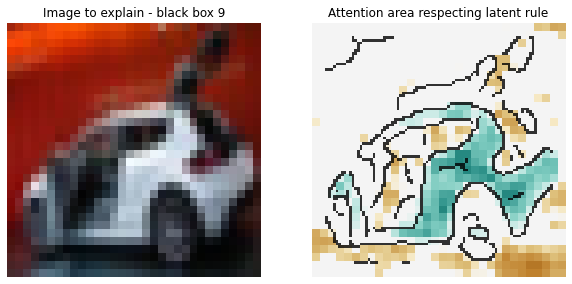

In [ ]:
"""
Arguments:
    features: [None] list of which feature of the latent space to use, If None use all
    samples: [10] number of prototype to use
Return the image and the difference between the prototypes
"""
img2show, mask = exp.getFeaturesImportance(features=None, samples=1500)

# Plot Script
F, ax = plt.subplots(1,2, figsize=(10,5))
if use_rgb:
    ax[0].imshow(img2show)
else:
    ax[0].imshow(img2show, cmap='gray')
bbo = bb_predict(np.array([img2show]))[0]
ax[0].set_title('Image to explain - black box %s' % bbo)
ax[0].axis('off')
dx, dy = 0.05, 0.05
xx = np.arange(0.0, img2show.shape[1], dx)
yy = np.arange(0.0, img2show.shape[0], dy)
xmin, xmax, ymin, ymax = np.amin(xx), np.amax(xx), np.amin(yy), np.amax(yy)
extent = xmin, xmax, ymin, ymax
cmap_xi = plt.get_cmap('Greys_r')
cmap_xi.set_bad(alpha=0)
# Compute edges (to overlay to heatmaps later)
percentile = 100
dilation = 3.0
alpha = 0.8
xi_greyscale = img2show if len(img2show.shape) == 2 else np.mean(img2show, axis=-1)
in_image_upscaled = transform.rescale(xi_greyscale, dilation, mode='constant')
edges = feature.canny(in_image_upscaled).astype(float)
edges[edges < 0.5] = np.nan
edges[:5, :] = np.nan
edges[-5:, :] = np.nan
edges[:, :5] = np.nan
edges[:, -5:] = np.nan
overlay = edges
ax[1].imshow(mask, extent=extent, cmap=plt.cm.BrBG, alpha=1, vmin=0, vmax=255)
ax[1].imshow(overlay, extent=extent, interpolation='none', cmap=cmap_xi, alpha=alpha)
ax[1].axis('off')
ax[1].set_title('Attention area respecting latent rule');

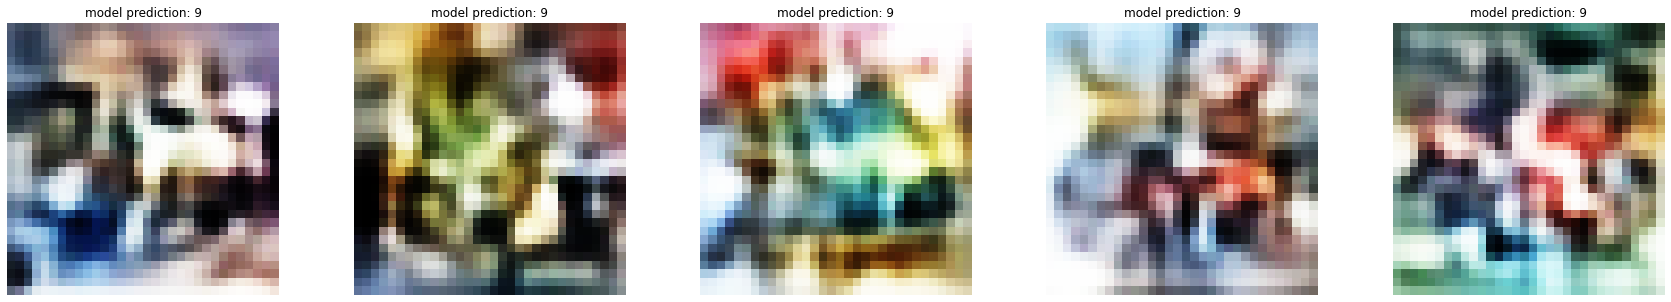

In [ ]:
"""
Return the prototypes images
Arguments:
    num_prototypes: [5]  maximum number of prototypes to return
    return_latent: [False] if True return latent representation
    return_diff: [False] If True return the difference with the query image
    features: [None] list of the features in the latent space to use, if none use all
"""
proto = exp.getExemplars(num_prototypes=5)
#print(proto)
#F, ax = plt.subplots(1,len(proto),figsize=(30,5))
#for i in range(len(proto)):
#    ax[i].imshow(proto[i])
#    ax[i].axis('off')

if len(proto)==1:
    plt.imshow(proto[0])
    plt.axis(False)
    plt.title('model prediction: '+str(bb_predict(proto[0][np.newaxis,:,:,:])[0]))
else:
    F, ax = plt.subplots(1,len(proto),figsize=(30,5))
    for i in range(len(proto)):
        ax[i].imshow(proto[i])
        ax[i].set_title('model prediction: '+str(bb_predict(proto[i][np.newaxis,:,:,:])[0]))
        ax[i].axis('off')

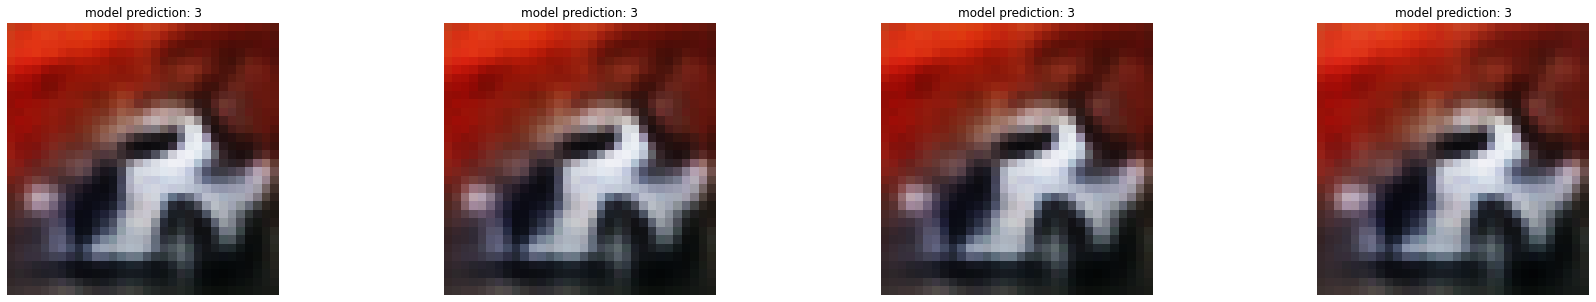

In [ ]:
"""
Return the couterfactuals satisfying the counterfactual rule
"""
counter = exp.getCounterExemplars()

if len(counter)==1:
    plt.imshow(counter[0])
    plt.axis(False)
    plt.title('model prediction: '+str(bb_predict(counter[0][np.newaxis,:,:,:])[0]))
else:
    F, ax = plt.subplots(1,len(counter),figsize=(30,5))
    for i in range(len(counter)):
        ax[i].imshow(counter[i])
        ax[i].set_title('model prediction: '+str(bb_predict(counter[i][np.newaxis,:,:,:])[0]))
        ax[i].axis('off')

In [ ]:
# index Image 2 Explain
img = test_images[15]
# time
start = time.time()

# create explainer
"""
Arguments:
    bb_predict: function which return the prediction of the blackbox in form index of the class 
    class_name: name of the class used when printing rules (class_name: class_value)
    class_values: list of names of the classes (class_name: class_value)
    neigh_type: select the nighbourhood type,
                supportecd types:
                'gnt' : genetic
                'rnd' : random
                'hrg' : hybrid-random-genetic
                'gntp': genetic probabilistic
                'hrgp': hybrid probabilistic
    ocr: [0.1] other class values, ratio of other class from the one predicted in the neighbourhood
    kernel: [None] Kernel to weights the point in the nieghbourhood
    kernel_width : [None]  
    autoencoder: Autoencoder to generate the latent space points
    use_rgb = [True] Set to True if the input images are rgb, False for grayscale
    filter_crules: [None] if True Prototypes are checked by the black box to be the same class of the query image
    random_state: set the seed of the random state
    verbose: True if you want to print more informations
    NEIGHBOURHOOD PARAMETERS: the following parameters are Neighbourhood specific and may not apply to all of the neighbourhood types
        valid_thr: [0.5] threshold to change class in the autoencoder disciminator
        alpha1: [0.5] weight of the feature similarity of the neighbourhood points
        alpha2: [0.5] weight of the target similarity of the neighbourhood points
        ngen: [100] number of generations of the genetic algorithm
        mutpb: [0.2] The probability of mutating an individual in the genetic algorithm
        cxpb: [0.5] The probability of mating two individuals in the genetic algorithm
        tournsize: [3] number of tournaments in the genetic algorithm
        hallooffame_ratio: [0.1] Fraction of exemplars to keep at every genetic generation
"""
config = {'bb_predict':bb_predict,
          'class_name':'class',
          'class_values':['%s' % i for i in range(len(np.unique(test_labels)))],
          'neigh_type':'hrg', 
          'ocr':0.1, #other class ratio in the neighbourhood
          'kernel_width':None, 
          'kernel':None, 
          'autoencoder':aae, 
          'use_rgb':True, 
          'filter_crules':False, 
          'random_state':random_state, 
          'verbose':True, 
          'valid_thr':0.5,
          'alpha1':0.5, 
          'alpha2':0.5, 
          'ngen':20, 
          'mutpb':0.2, 
          'cxpb':0.5, 
          'tournsize':3, 
          'halloffame_ratio':0.1}


explainer = ABELEImageExplainer(bb)
explainer.fit(config)

#generate explanation
"""
generate an explanation for a given image
Arguments:
    img: the image to explain
    num_samples: [1000] number of samples to generate with the neighbourhood algorithm
    use_weights: [True] if weights the points using distance
Return:
Explanation object compose by several things
    rstr: string describing the rule
    cstr: string describing the counterfactual rule
    bb_pred: black box prediction of the image
    dt_pred: decisoon tree prediction
    fidelity: fidelity between black box and the decision tree
    limg: latent space representation of the image
"""
exp = explainer.explain(img, num_samples=500, use_weights=True)

# time
end = time.time()
print('--------------------------')
print('execution time: ',end - start,' sec')
print('e = {\n\tr = %s\n\tc = %s    \n}' % (exp.getRules(), exp.getCounterfactualRules()))
print('--------------------------')
print('bb prediction of the image: ',exp.exp.bb_pred,'dt prediction: ',exp.exp.dt_pred,'fidelity: ',exp.exp.fidelity)
print('latent space representation: ',exp.exp.limg)

generating neighborhood - hrg
gen	nevals	avg     	min     	max     
0  	125   	0.496654	0.496654	0.496654
1  	87    	0.535139	0.476671	0.990159
2  	78    	0.612735	0.465847	0.993263
3  	81    	0.776194	0.444785	0.993263
4  	67    	0.908716	0.453456	0.993263
5  	78    	0.918199	0.475893	0.993263
6  	79    	0.947368	0.480212	0.993263
7  	72    	0.904483	0.485342	0.993263
8  	72    	0.931786	0.470176	0.993263
9  	71    	0.916349	0.48499 	0.993263
10 	72    	0.960171	0.486076	0.993263
11 	57    	0.940595	0.485921	0.993263
12 	68    	0.940398	0.477443	0.993263
13 	70    	0.927784	0.483883	0.993263
14 	74    	0.939888	0.487978	0.993263
15 	76    	0.932255	0.477303	0.993263
16 	80    	0.936394	0.47329 	0.993263
17 	73    	0.944482	0.480944	0.993263
18 	72    	0.924347	0.485107	0.993263
19 	71    	0.931775	0.476611	0.993263
20 	73    	0.936097	0.486345	0.993263
gen	nevals	avg	min	max
0  	125   	0.5	0.5	0.5
1  	81    	0.557097	0.488759	0.988054
2  	89    	0.71426 	0.448892	0.99147 
3  	81    	0

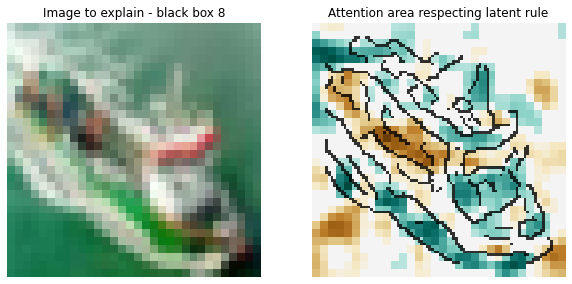

In [ ]:
"""
Arguments:
    features: [None] list of which feature of the latent space to use, If None use all
    samples: [10] number of prototype to use
Return the image and the difference between the prototypes
"""
img2show, mask = exp.getFeaturesImportance(features=None, samples=1500)

# Plot Script
F, ax = plt.subplots(1,2, figsize=(10,5))
if use_rgb:
    ax[0].imshow(img2show)
else:
    ax[0].imshow(img2show, cmap='gray')
bbo = bb_predict(np.array([img2show]))[0]
ax[0].set_title('Image to explain - black box %s' % bbo)
ax[0].axis('off')
dx, dy = 0.05, 0.05
xx = np.arange(0.0, img2show.shape[1], dx)
yy = np.arange(0.0, img2show.shape[0], dy)
xmin, xmax, ymin, ymax = np.amin(xx), np.amax(xx), np.amin(yy), np.amax(yy)
extent = xmin, xmax, ymin, ymax
cmap_xi = plt.get_cmap('Greys_r')
cmap_xi.set_bad(alpha=0)
# Compute edges (to overlay to heatmaps later)
percentile = 100
dilation = 3.0
alpha = 0.8
xi_greyscale = img2show if len(img2show.shape) == 2 else np.mean(img2show, axis=-1)
in_image_upscaled = transform.rescale(xi_greyscale, dilation, mode='constant')
edges = feature.canny(in_image_upscaled).astype(float)
edges[edges < 0.5] = np.nan
edges[:5, :] = np.nan
edges[-5:, :] = np.nan
edges[:, :5] = np.nan
edges[:, -5:] = np.nan
overlay = edges
ax[1].imshow(mask, extent=extent, cmap=plt.cm.BrBG, alpha=1, vmin=0, vmax=255)
ax[1].imshow(overlay, extent=extent, interpolation='none', cmap=cmap_xi, alpha=alpha)
ax[1].axis('off')
ax[1].set_title('Attention area respecting latent rule');

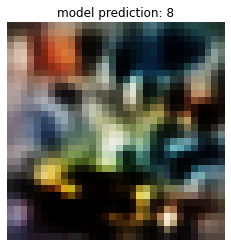

In [ ]:
"""
Return the prototypes images
Arguments:
    num_prototypes: [5]  maximum number of prototypes to return
    return_latent: [False] if True return latent representation
    return_diff: [False] If True return the difference with the query image
    features: [None] list of the features in the latent space to use, if none use all
"""
proto = exp.getExemplars(num_prototypes=5)
#print(proto)
#F, ax = plt.subplots(1,len(proto),figsize=(30,5))
#for i in range(len(proto)):
#    ax[i].imshow(proto[i])
#    ax[i].axis('off')

if len(proto)==1:
    plt.imshow(proto[0])
    plt.axis(False)
    plt.title('model prediction: '+str(bb_predict(proto[0][np.newaxis,:,:,:])[0]))
else:
    F, ax = plt.subplots(1,len(proto),figsize=(30,5))
    for i in range(len(proto)):
        ax[i].imshow(proto[i])
        ax[i].set_title('model prediction: '+str(bb_predict(proto[i][np.newaxis,:,:,:])[0]))
        ax[i].axis('off')

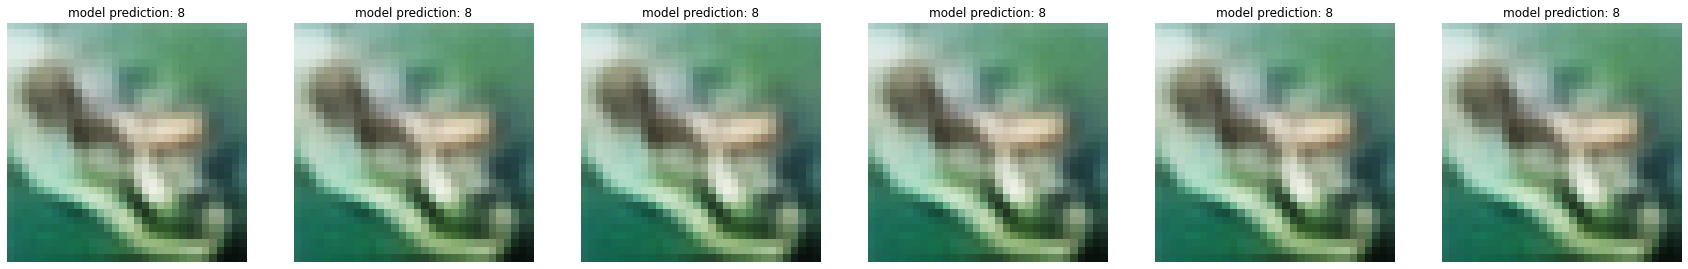

In [ ]:
"""
Return the couterfactuals satisfying the counterfactual rule
"""
counter = exp.getCounterExemplars()

if len(counter)==1:
    plt.imshow(counter[0])
    plt.axis(False)
    plt.title('model prediction: '+str(bb_predict(counter[0][np.newaxis,:,:,:])[0]))
else:
    F, ax = plt.subplots(1,len(counter),figsize=(30,5))
    for i in range(len(counter)):
        ax[i].imshow(counter[i])
        ax[i].set_title('model prediction: '+str(bb_predict(counter[i][np.newaxis,:,:,:])[0]))
        ax[i].axis('off')

In [ ]:
"""
Arguments:
    features: [None] list of which feature of the latent space to use, If None use all
    samples: [10] number of prototype to use
Return the image and the difference between the prototypes
"""
img2show, mask = exp.get_image_rule(features=None, samples=1000)

# Plot Script
F, ax = plt.subplots(1,2, figsize=(10,5))
if use_rgb:
    ax[0].imshow(img2show)
else:
    ax[0].imshow(img2show, cmap='gray')
bbo = bb_predict(np.array([img2show]))[0]
ax[0].set_title('Image to explain - black box %s' % bbo)
ax[0].axis('off')
dx, dy = 0.05, 0.05
xx = np.arange(0.0, img2show.shape[1], dx)
yy = np.arange(0.0, img2show.shape[0], dy)
xmin, xmax, ymin, ymax = np.amin(xx), np.amax(xx), np.amin(yy), np.amax(yy)
extent = xmin, xmax, ymin, ymax
cmap_xi = plt.get_cmap('Greys_r')
cmap_xi.set_bad(alpha=0)
# Compute edges (to overlay to heatmaps later)
percentile = 100
dilation = 3.0
alpha = 0.8
xi_greyscale = img2show if len(img2show.shape) == 2 else np.mean(img2show, axis=-1)
in_image_upscaled = transform.rescale(xi_greyscale, dilation, mode='constant')
edges = feature.canny(in_image_upscaled).astype(float)
edges[edges < 0.5] = np.nan
edges[:5, :] = np.nan
edges[-5:, :] = np.nan
edges[:, :5] = np.nan
edges[:, -5:] = np.nan
overlay = edges
ax[1].imshow(mask, extent=extent, cmap=plt.cm.BrBG, alpha=1, vmin=0, vmax=255)
ax[1].imshow(overlay, extent=extent, interpolation='none', cmap=cmap_xi, alpha=alpha)
ax[1].axis('off')
ax[1].set_title('Attention area respecting latent rule');

Exception: ignored

In [ ]:
"""
Return the prototypes images
Arguments:
    num_prototypes: [5] number of prototypes to return
    return_latent: [False] if True return latent representation
    return_diff: [False] If True return the difference with the query image
    features: [None] list of the features int he latent space to use, if none use all
"""
proto = exp.get_prototypes_respecting_rule(num_prototypes=5)

F, ax = plt.subplots(1,5,figsize=(30,5))
for i in range(5):
    ax[i].imshow(proto[i])
    ax[i].axis('off')
    ax[i].set_title('model prediction: '+str(bb_predict(proto[0][np.newaxis,:,:,:])[0]))

In [ ]:
"""
Return the couterfactuals satisfying the counterfactual rule
"""
counter = exp.get_counterfactual_prototypes()

F, ax = plt.subplots(1,len(counter),figsize=(30,5))
if len(counter)==0:
    print('no counterfactual found')
elif len(counter)==1:
    plt.imshow(counter[0])
    plt.axis('off')
    plt.set_title('model prediction: '+str(bb_predict(counter[0])[0]))    
for i in range(len(counter)):
    ax[i].imshow(counter[i])
    ax[i].axis('off')
    ax[i].set_title('model prediction: '+str(bb_predict(counter[i][np.newaxis,:,:,:])[0]))